In [1]:
import cv2
import numpy as np
import torch
import torchvision.transforms.functional as F
from matplotlib import pyplot as plt
from torchvision.io import decode_image

from wings.config import MODELS_DIR, PROCESSED_DATA_DIR, RAW_DATA_DIR, IMG_FOLDER_SUFX
from wings.modeling.litnet import LitNet
from wings.modeling.loss import DiceLoss
from wings.visualizing.visualize import visualize_coords

2025-05-29 15:34:19.110 | INFO     | wings.config:<module>:40 - PROJ_ROOT path is: /home/mkrajew/bees
2025-05-29 15:34:19.210 | INFO     | wings.config:<module>:62 - torch.cuda.get_device_name()='NVIDIA RTX A3000 12GB Laptop GPU'


In [2]:
test_dataset = torch.load(PROCESSED_DATA_DIR / "mask_datasets" / 'square5' / "test_mask_dataset2.pth", weights_only=False)
checkpoint_path = MODELS_DIR / 'unet-epoch=05-val_loss=0.11-unet-training_1.ckpt'
unet_model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False
)
num_epochs = 60
model = LitNet.load_from_checkpoint(checkpoint_path, model=unet_model, num_epochs=num_epochs, criterion=DiceLoss())
model.eval()

max_n = len(test_dataset)

Using cache found in /home/mkrajew/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


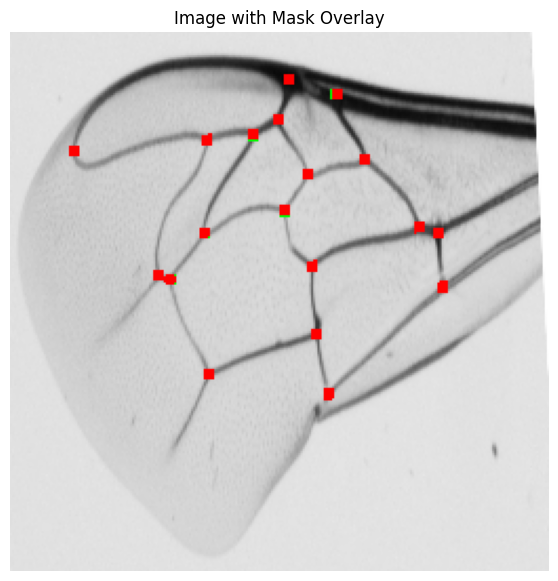

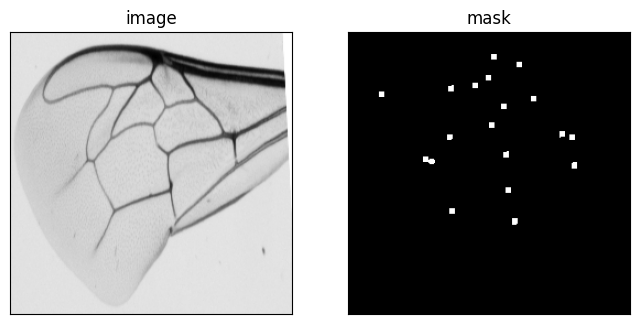

In [3]:
n = np.random.randint(0, max_n)
image, label, coords, orig_size = test_dataset[n]
original_dataset = test_dataset.dataset  # this gives you the original dataset
filename = original_dataset.coords_df.loc[test_dataset.indices[n], 'file']
output = model(image.cuda().unsqueeze(0))

country = filename.split('-', 1)[0]
img = decode_image(str(RAW_DATA_DIR / f"{country}{IMG_FOLDER_SUFX}" / filename))
img = F.resize(img, [256, 256], interpolation=F.InterpolationMode.BILINEAR, antialias=False)
img = img.numpy().transpose(1, 2, 0)

mask = torch.round(output).squeeze().detach().cpu().numpy()
labels = torch.round(label).squeeze().detach().cpu().numpy()

image_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Create boolean mask for white pixels in mask
white_areas = mask == 1
target_areas = labels == 1

# Set those areas to red (BGR: [0, 0, 255])
image_bgr[target_areas] = [0, 255, 0]
image_bgr[white_areas] = [0, 0, 255]

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Show the result
plt.figure(figsize=(7, 7))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Image with Mask Overlay")
# plt.show()

_, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(img, cmap="gray")
ax[0].set_title("image")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("mask")
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

float32
<class 'numpy.ndarray'>
(256, 256)
1.0


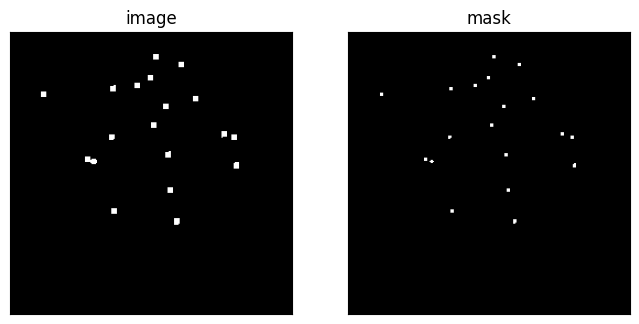

Coordinates of white spots: [(150, 171), (94, 162), (145, 143), (205, 120), (75, 117), (70, 115), (143, 111), (203, 95), (91, 94), (194, 92), (130, 84), (141, 67), (168, 60), (30, 56), (93, 51), (115, 48), (127, 41), (155, 29), (132, 22)]
len(coordinates)=19


In [4]:
import cv2

print(mask.dtype)
print(type(mask))
print(mask.shape)
print(mask.max())

binary = (mask * 255).astype(np.uint8)

kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
binary_eroded = cv2.erode(binary, kernel, iterations=1)

_, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(binary, cmap="gray")
ax[0].set_title("image")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(binary_eroded, cmap="gray")
ax[1].set_title("mask")
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

_, binary_eroded = cv2.threshold(binary_eroded, 200, 255, cv2.THRESH_BINARY)

# Find contours of the white spots
contours, _ = cv2.findContours(binary_eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get center coordinates of each contour
coordinates = []
for cnt in contours:
    M = cv2.moments(cnt)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])  # x coordinate of centroid
        cy = int(M['m01'] / M['m00'])  # y coordinate of centroid
        coordinates.append((cx, cy))

print("Coordinates of white spots:", coordinates)
print(f"{len(coordinates)=}")


In [5]:
from wings.visualizing.image_preprocess import mask_to_coords
from wings.utils import order_coords
from sklearn.metrics import mean_squared_error

try:
    mask_coords = mask_to_coords(mask)
    print(mask_coords)
    mask_coords, original_coords = order_coords(mask_coords, coords)
    mse_sklearn = mean_squared_error(original_coords, mask_coords)
    print(mse_sklearn)
except Exception as e:
    print(e)


[(150, 84), (94, 93), (145, 112), (205, 135), (75, 138), (70, 140), (143, 144), (203, 160), (91, 161), (194, 163), (130, 171), (141, 188), (168, 195), (30, 199), (93, 204), (115, 207), (127, 214), (155, 226), (132, 233)]
46128.52734375


In [6]:
total_mse = 0
num_samples = 0
bad_masks = 0

for image, label, original_coords, orig_size in test_dataset:
    output = model(image.cuda().unsqueeze(0))
    mask = torch.round(output).squeeze().detach().cpu().numpy()
    try:
        mask_coords = mask_to_coords(mask, max_iter=2)

        mask_height, mask_width = mask.shape
        orig_width, orig_height = orig_size
        scale_x = orig_width / mask_width
        scale_y = orig_height / mask_height
        mask_coords = [(x * scale_x, y * scale_y) for x, y in mask_coords]

        mask_coords, original_coords = order_coords(mask_coords, original_coords)

        mse = mean_squared_error(original_coords, mask_coords)
        total_mse += mse
        num_samples += 1
    except Exception as e:
        bad_masks += 1

In [7]:
print(f"{bad_masks=}")
print(f"all masks:\t{bad_masks + num_samples}.")
print(f"bad rate:\t{bad_masks / (num_samples + bad_masks) * 100:.2f}%.")
average_mse = total_mse / (num_samples - bad_masks) if num_samples > 0 else float('nan')
print(f"Average MSE over the dataset: {average_mse:.3f}")


bad_masks=97
all masks:	2172.
bad rate:	4.47%.
Average MSE over the dataset: 4.355


# Visualize final coords

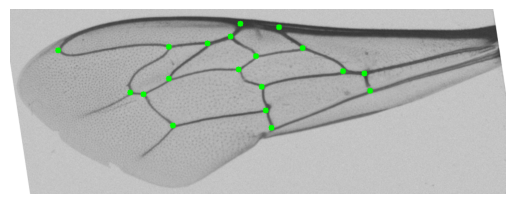

In [8]:
n = np.random.randint(0, max_n)
image, _, coords, orig_size = test_dataset[n]
original_dataset = test_dataset.dataset  # this gives you the original dataset
filename = original_dataset.coords_df.loc[test_dataset.indices[n], 'file']

output = model(image.cuda().unsqueeze(0))
mask = torch.round(output).squeeze().detach().cpu().numpy()

country = filename.split('-', 1)[0]
imgpath = RAW_DATA_DIR / f"{country}{IMG_FOLDER_SUFX}" / filename
img = cv2.imread(imgpath, cv2.IMREAD_COLOR)

try:
    mask_coords = mask_to_coords(mask, max_iter=2)

    mask_height, mask_width = mask.shape
    orig_width, orig_height = orig_size
    scale_x = orig_width / mask_width
    scale_y = orig_height / mask_height
    mask_coords = [(x * scale_x, y * scale_y) for x, y in mask_coords]

    mask_coords, original_coords = order_coords(mask_coords, coords)
    flat_coords = [coord for pair in mask_coords for coord in pair]  # Flatten list of tuples
    target_tensor = torch.tensor(flat_coords, dtype=torch.float32)

    # Visualize
    visualize_coords(img, target_tensor, spot_size=5)

except Exception as e:
    print(e)
